**Imports**

In [1]:
%matplotlib inline

# Conda imports
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from kneed import KneeLocator
from matplotlib.ticker import PercentFormatter
from scipy.linalg import subspace_angles
from scipy.stats.stats import pearsonr

# Local imports
import common
import helpers
import processing.statistics as statistics
from data import get_mnist, get_cifar
from experiment import Experiment
from processing.snapshots import Snapshots

## Loading a model

In [2]:
def results_path(output_dir, layers):
    fp_paths ={}
    ip_paths = {}
    norms_paths = {}
    for layer in layers:
        fp_paths[layer] = helpers.train_results_path(output_dir, common.FP_PREFIX, layer)
        ip_paths[layer] = helpers.train_results_path(output_dir, common.IP_PREFIX, layer)
        norms_paths[layer] = helpers.train_results_path(output_dir, common.NORM_PREFIX, layer)
        
    return fp_paths, ip_paths, norms_paths

In [3]:
conv2_output = "out/Conv2-28_11_2019-10:21:39"
conv4_output = "out/Conv4-28_11_2019-18:17:15"
conv6_output = "out/Conv6-28_11_2019-18:23:42"
vgg_output = "out/VGG11-13_12_2019-16:59:59"
vgg_output_bis = "out/VGG19_BN/VGG19_BN-17_12_2019-09:44:20"

output_dir = vgg_output_bis  # changeme
layers = ["conv2", "fc1", "fc2"]
fp_paths, ip_paths, norms_paths = results_path(output_dir, layers)

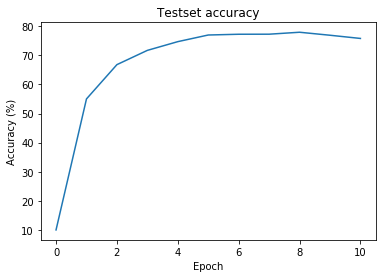

In [93]:
helpers.plot_test_acc(output_dir)

In [94]:
acc_path = os.path.join(output_dir, common.METRICS_DIR, common.TRAINING_DIR, common.ACCURACY_FNAME)
test_accuracies = np.load(acc_path)
print("Best test accuracy at epoch N°", np.argmax(test_accuracies))

Best test accuracy at epoch N° 8


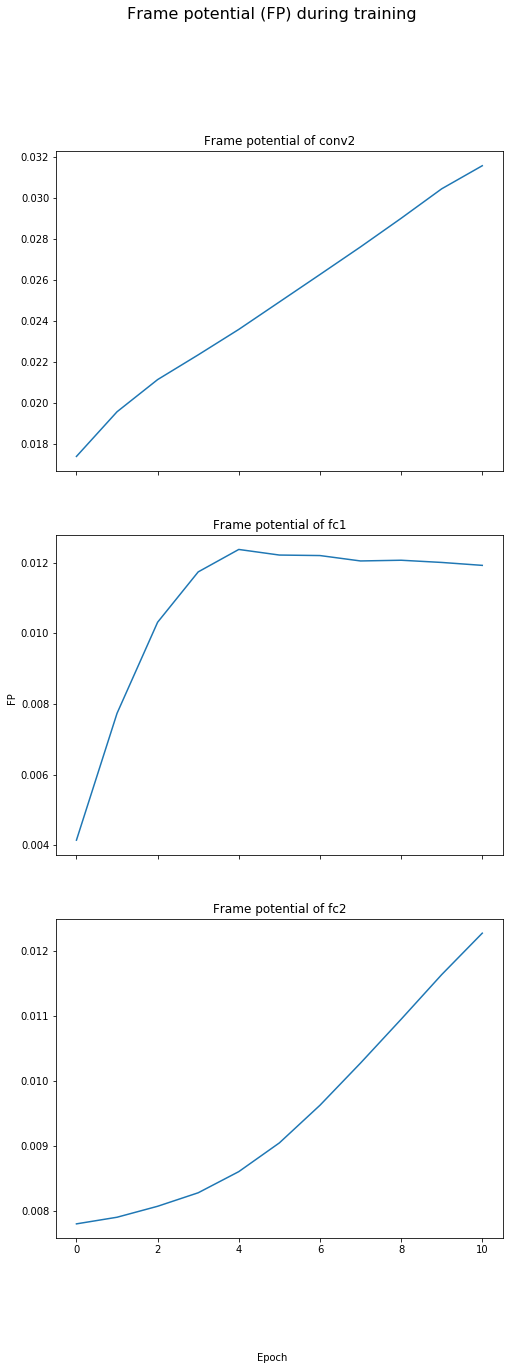

In [95]:
helpers.plot_train_fps(fp_paths, layers)

## Analysis of a layer

In [6]:
# Because of overfitting, we might want to restrict the analysis to the first n epochs
epochs = 2
has_accuracy = False
if has_accuracy:
    epochs = np.argmax(test_accuracies) + 1
layer = "fc2"
weight_norms = np.load(norms_paths[layer])[:epochs]
s = Snapshots(output_dir)
weights = s.get_weights(layer)[:epochs]

### 1. Plot of L2-norm distribution

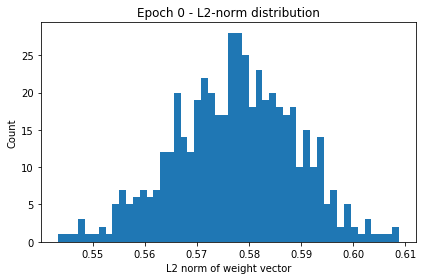

In [7]:
def norm_distribution(norms, epoch):
    fig, ax = plt.subplots(tight_layout=True)
    ax.hist(norms[epoch], bins=50)
    ax.set_xlabel("L2 norm of weight vector")
    ax.set_ylabel("Count")
    ax.set_title(f"Epoch {epoch} - L2-norm distribution")
    plt.show()
    
norm_distribution(weight_norms, 0)

Let's look at the evolution of weigh vector norms during training. The visualisation indicates that some weight vectors are selected for training, that is they experience an increase in $\ell_2$-norm, whereas others do not.

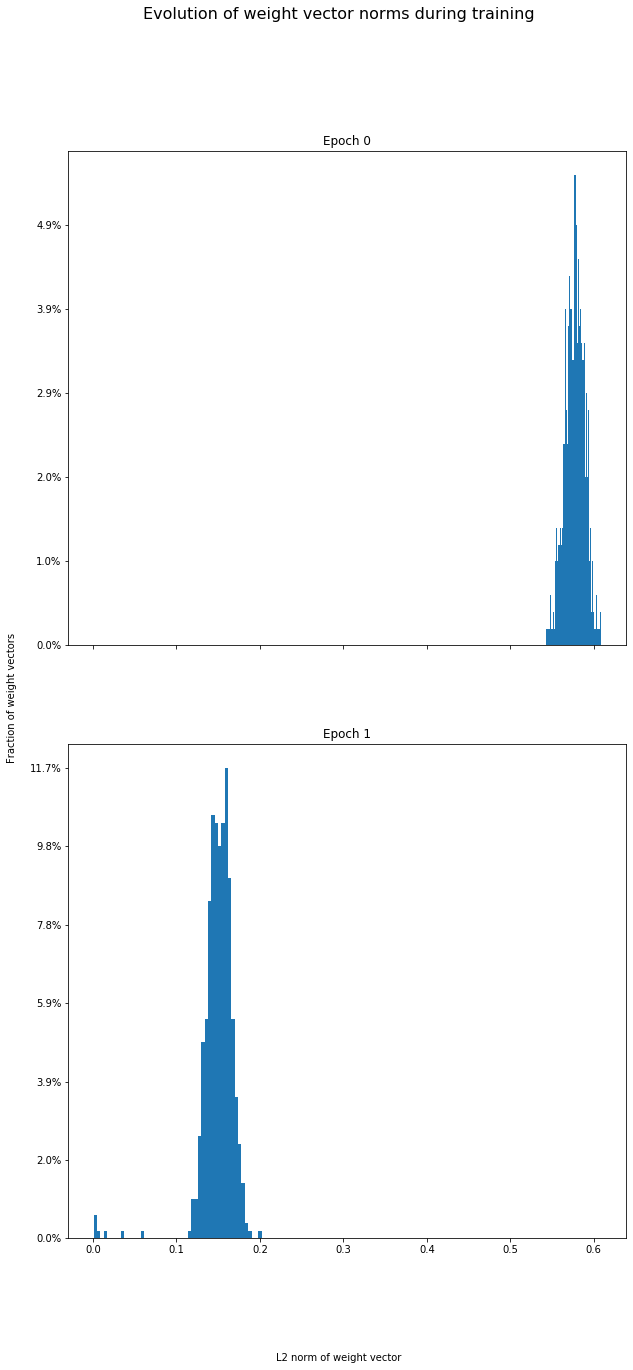

In [8]:
def plot_training_norms(norms):
    epochs = norms.shape[0]
    fig, axs = plt.subplots(epochs, 1, figsize=(10, 20), sharex=True)

    for epoch in range(norms.shape[0]):
        axs[epoch].hist(norms[epoch], bins=50)
        axs[epoch].yaxis.set_major_formatter(PercentFormatter(xmax=norms.shape[1]))
        axs[epoch].set_title(f"Epoch {epoch}")

    fig.suptitle("Evolution of weight vector norms during training", fontsize=16)
    fig.text(0.5, 0.04, 'L2 norm of weight vector', ha='center')
    fig.text(0.04, 0.5, 'Fraction of weight vectors', va='center', rotation='vertical')

    plt.show()
    
plot_training_norms(weight_norms)

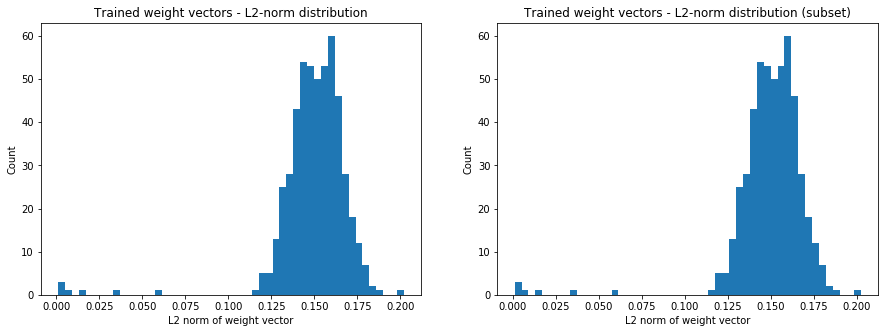

In [9]:
def trained_vector_norms(norms, cut_off=0.8):
    final_norms = norms[-1]
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    hist = axs[0].hist(final_norms, bins=50)
    axs[0].set_xlabel("L2 norm of weight vector")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Trained weight vectors - L2-norm distribution")
    selected_norms = final_norms[final_norms < cut_off]
    hist = axs[1].hist(selected_norms, bins=50)
    axs[1].set_xlabel("L2 norm of weight vector")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Trained weight vectors - L2-norm distribution (subset)")
    plt.show()
    
trained_vector_norms(weight_norms)

### 2. Analysis of space spanned by weight vectors

Before performing a singular value decomposition on the matrix whose columns represent weight vectors (rows of our initial weight matrix) of the first fully connected layer, we normalize the weight vectors.

In [10]:
w = torch.zeros(weights.shape)
# Normalize the weight vectors for every epoch
for epoch in range(epochs):
    w[epoch] = F.normalize(weights[epoch], p=2, dim=1)

In [11]:
def svd(selected_weights):
    epochs, n_params, param_length = selected_weights.shape
    k = min(n_params, param_length)
    u = np.zeros((epochs, param_length, k))
    s = np.zeros((epochs, k))
    vh = np.zeros((epochs, k, n_params))

    for epoch in range(epochs):
        # Look at space spanned by the rows of the weight matrix
        w_epoch = selected_weights[epoch].numpy().T
        u_epoch, s_epoch, vh_epoch = np.linalg.svd(w_epoch, full_matrices=False)
        u[epoch] = u_epoch
        s[epoch] = s_epoch
        vh[epoch] = vh_epoch
    
    return u, s, vh

In [12]:
def singular_value_distribution(s):
    epochs = s.shape[0]
    fig, axs = plt.subplots(epochs, 1, figsize=(10, 20), sharex=True)

    for epoch in range(epochs):
        axs[epoch].hist(s[epoch], bins=50)
        axs[epoch].yaxis.set_major_formatter(PercentFormatter(xmax=s.shape[1]))
        axs[epoch].set_title(f"Epoch {epoch}")

    fig.suptitle("Evolution of singular values during training", fontsize=16)
    fig.text(0.5, 0.04, 'Value', ha='center')
    fig.text(0.04, 0.5, 'Fraction of singular values', va='center', rotation='vertical')

    plt.show()

In [13]:
def svd_comparison(s, *, fig_name=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    hist = axs[0].hist(s[0], bins=40)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Count")
    axs[0].set_title("ESD of untrained matrix")
    hist = axs[1].hist(s[-1], bins=40)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Count")
    axs[1].set_title("ESD of trained matrix")
    if fig_name:
        fig_path = os.path.join("out/figures", fig_name)
        plt.savefig(fig_path, format="png")
    else:
        plt.show()

In [14]:
u_full, s_full, vh_full = svd(weights)  # w

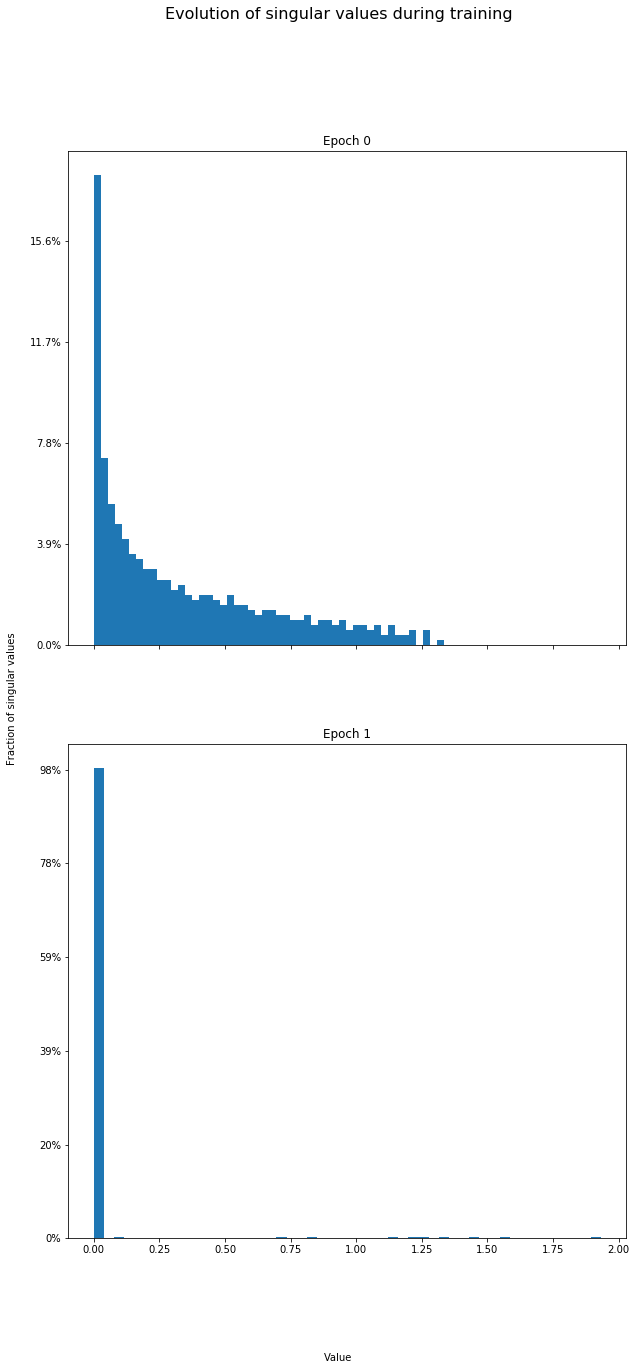

In [15]:
singular_value_distribution(s_full**2)

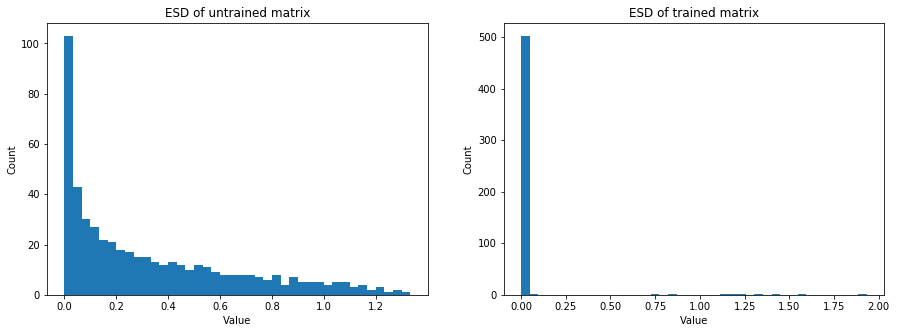

In [16]:
svd_comparison(s_full**2)  #, fig_name="vgg-fc1-svd-comp.png")

We distinguish between 3 types of singular values:
- Less than 1: Noise, less important directions
- Close to 1: directions that appear just once
- Greater than 1: directions that have a high inner product with multiple weight vectors (subspace)

### 3. Looking at selected weight vectors

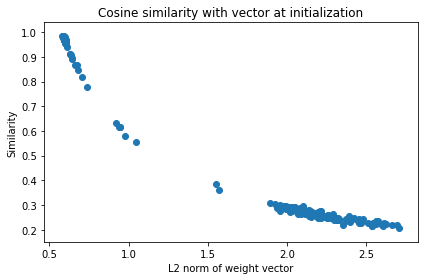

In [18]:
def plot_trained_similarity(weights, norms):
    fig, ax = plt.subplots(tight_layout=True)
    start = weights[0].numpy().T
    end = weights[-1].numpy().T
    similarity = np.diag(start.T @ end)
    ax.scatter(norms[-1], similarity)
    ax.set_xlabel("L2 norm of weight vector")
    ax.set_ylabel("Similarity")
    ax.set_title("Cosine similarity with vector at initialization")
    plt.show()
    
plot_trained_similarity(w, weight_norms)

The $\ell_2$-norm seems indeed to be a good indicator of a neuron's saliency, which leads us to the following separation:

In [19]:
cutoff = 1.2
trained_neurons = (weight_norms[-1] > cutoff)
selected_neurons = np.argwhere(trained_neurons).flatten().tolist()
unselected_neurons = np.argwhere(~trained_neurons).flatten().tolist()

In [20]:
u_selected, s_selected, vh_selected = svd(weights[:, selected_neurons, :])

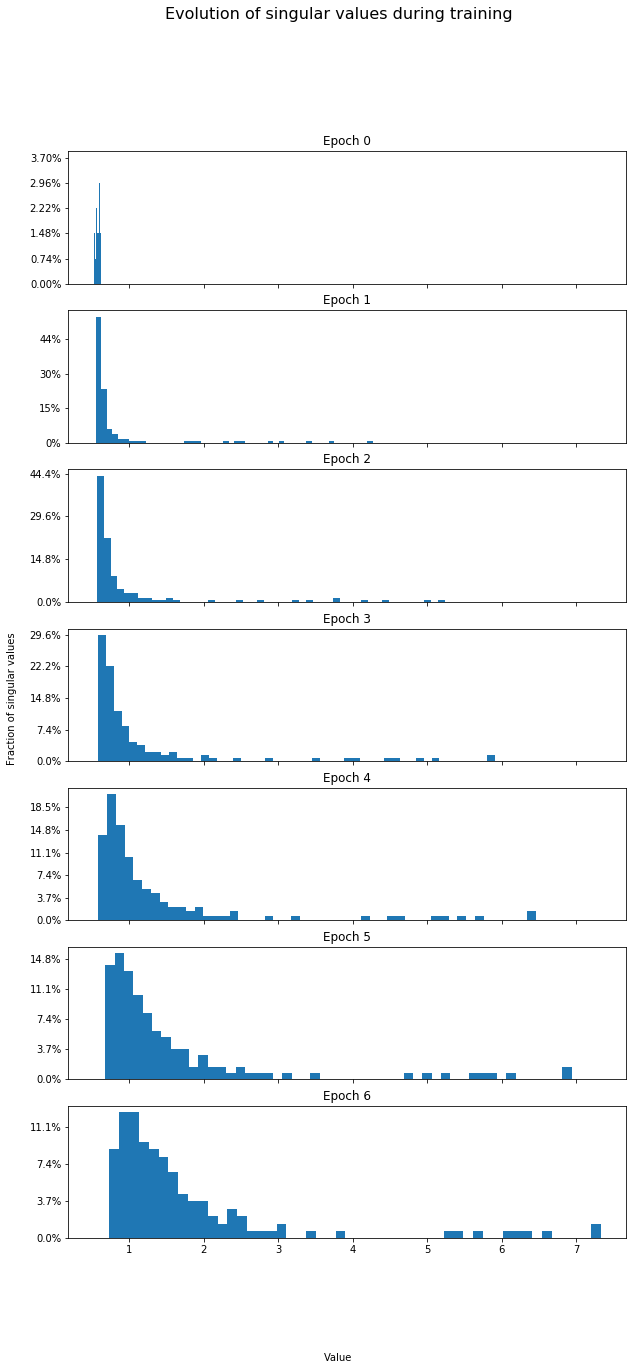

In [21]:
singular_value_distribution(s_selected)

This supports the hypothesis of a *trained subspace*, which contains all of the trained vectors and is of low dimensionality.

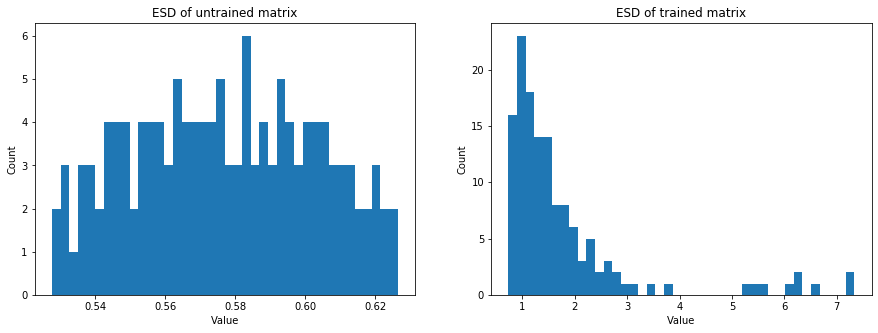

In [22]:
svd_comparison(s_selected)

### 4. Looking at unselected weight vectors

In [23]:
u_unselected, s_unselected, vh_unselected = svd(weights[:, unselected_neurons, :])

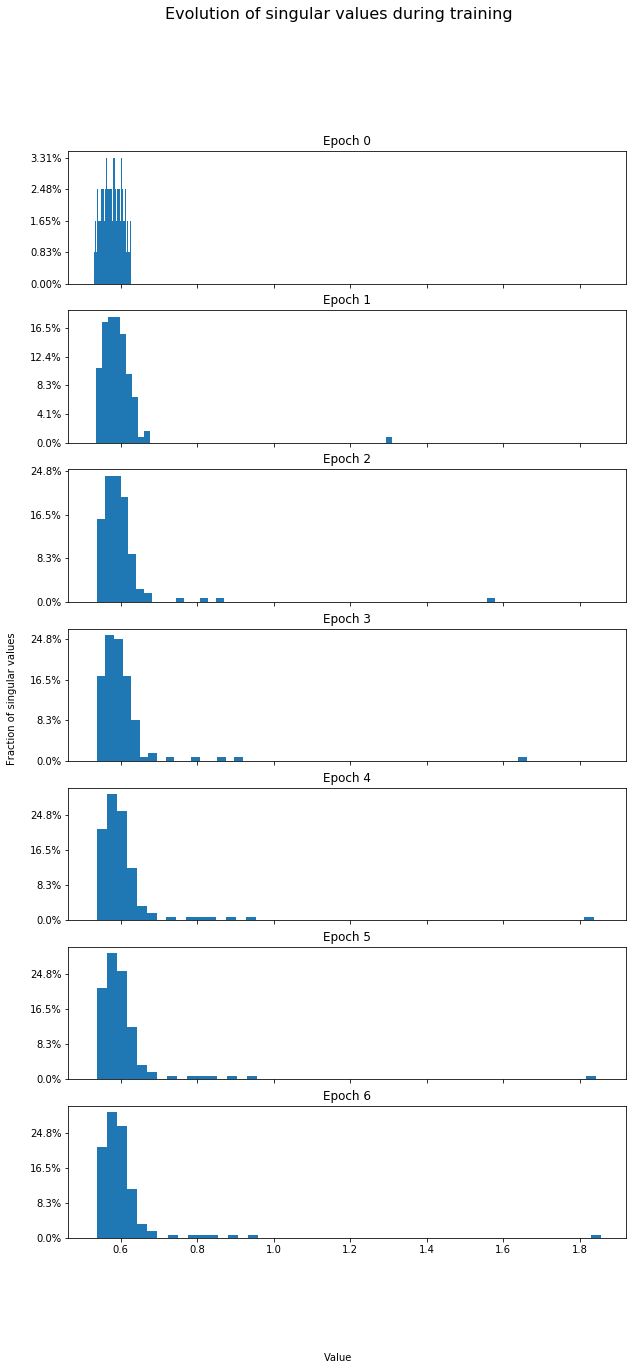

In [24]:
singular_value_distribution(s_unselected)

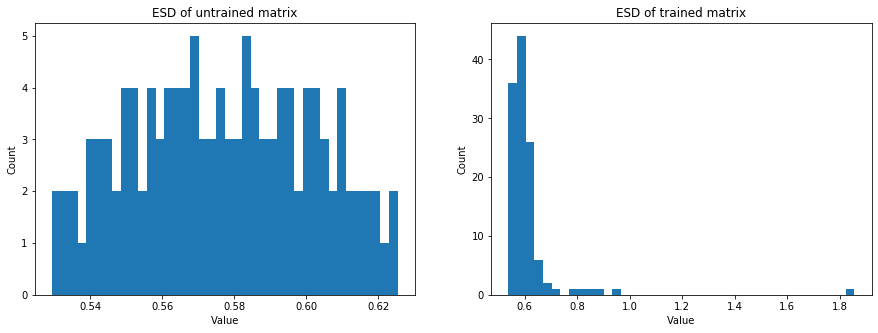

In [25]:
svd_comparison(s_unselected)

### 5. Comparing selected and unselected weight vectors

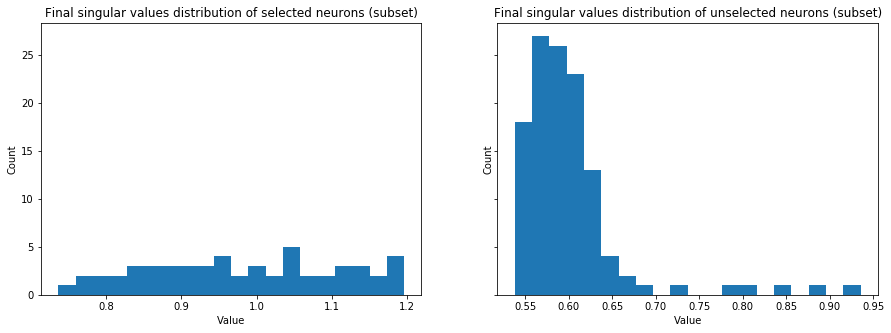

In [26]:
def selection_comparison(s1, s2):
    final_svs = s1[-1]
    s_filtered = final_svs[final_svs < 1.2]
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    hist = axs[0].hist(s_filtered, bins=20)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Final singular values distribution of selected neurons (subset)")
    final_svs = s2[-1]
    s_filtered = final_svs[final_svs < 1.2]
    hist = axs[1].hist(s_filtered, bins=20)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Final singular values distribution of unselected neurons (subset)")
    plt.show()
    
selection_comparison(s_selected, s_unselected)

### 6. Low-rank approximation

Next we perform a low-rank approximation of the subspace spanned by the trained weight vectors. We plot the reconstruction error as a function of the chosen rank of approximation.

In [17]:
def plot_reconstruction_error(s):
    epochs = s.shape[0]
    squared_s = s**2
    fig, axs = plt.subplots(epochs, 2, figsize=(14, 20), sharex=True)

    for epoch in range(epochs):
        s_epoch = squared_s[epoch]
        res = np.array([s_epoch[i:].sum() for i in range(s_epoch.size+1)])
        diff = res[1:] - res[:-1]
        
        kn = KneeLocator(range(res.size), res, curve='convex', direction='decreasing')
        elbow = kn.knee
        
        axs[epoch][0].plot(res)
        axs[epoch][0].axvline(elbow, color='red', linestyle='-.', linewidth=1.0, label="Elbow at k={}".format(elbow))
        axs[epoch][0].set_ylabel("RE")
        axs[epoch][0].set_title(f"Epoch {epoch}: RE plot")
        axs[epoch][0].legend()
        axs[epoch][1].plot(diff)
        axs[epoch][1].set_ylabel("Differentiated RE")
        axs[epoch][1].set_title(f"Epoch {epoch}: Differentiated RE plot")

    fig.suptitle("Reconstruction error (RE) when performing a low-rank approximation", fontsize=16)
    fig.text(0.5, 0.04, 'Rank of approximation', ha='center')

    plt.show()

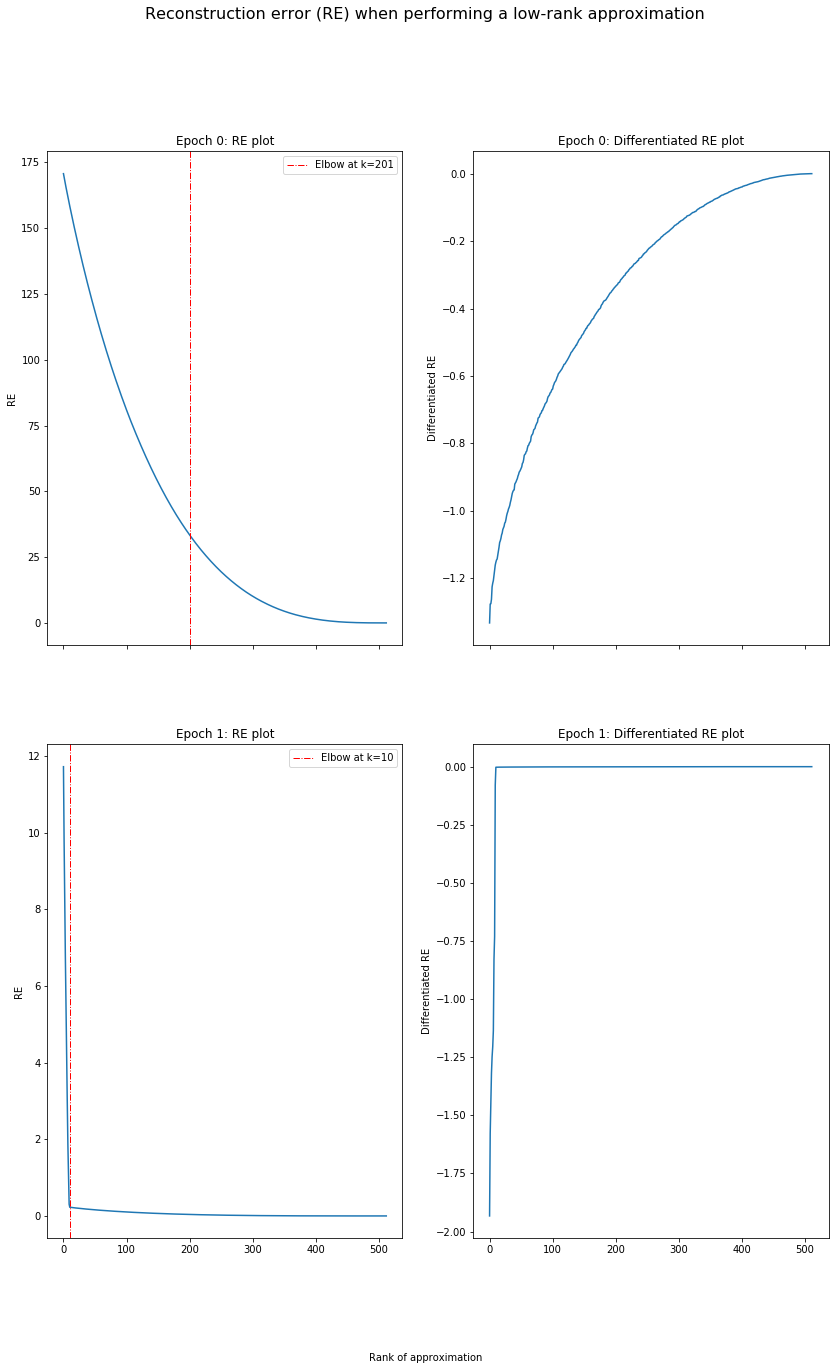

In [18]:
res_full = plot_reconstruction_error(s_full)

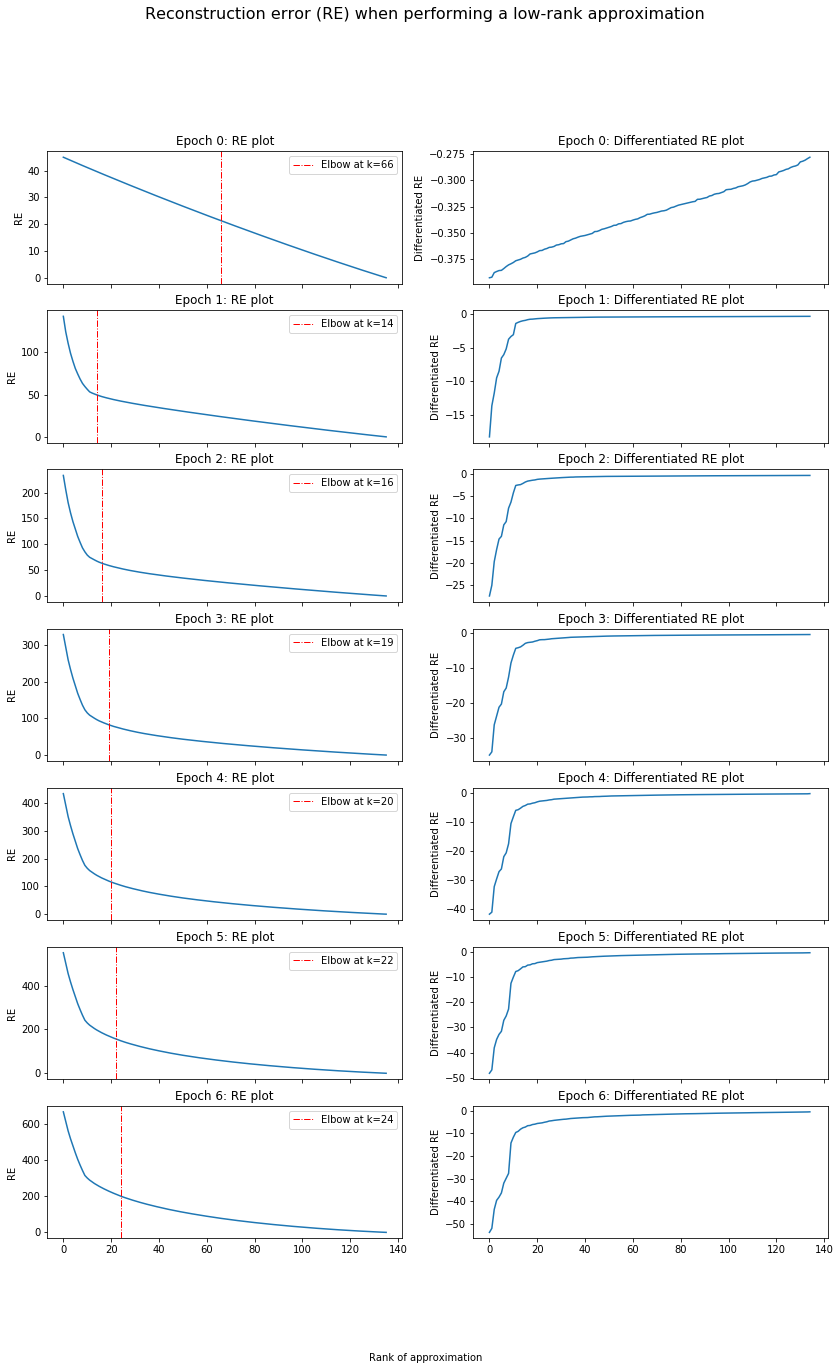

In [29]:
res_selected = plot_reconstruction_error(s_selected)

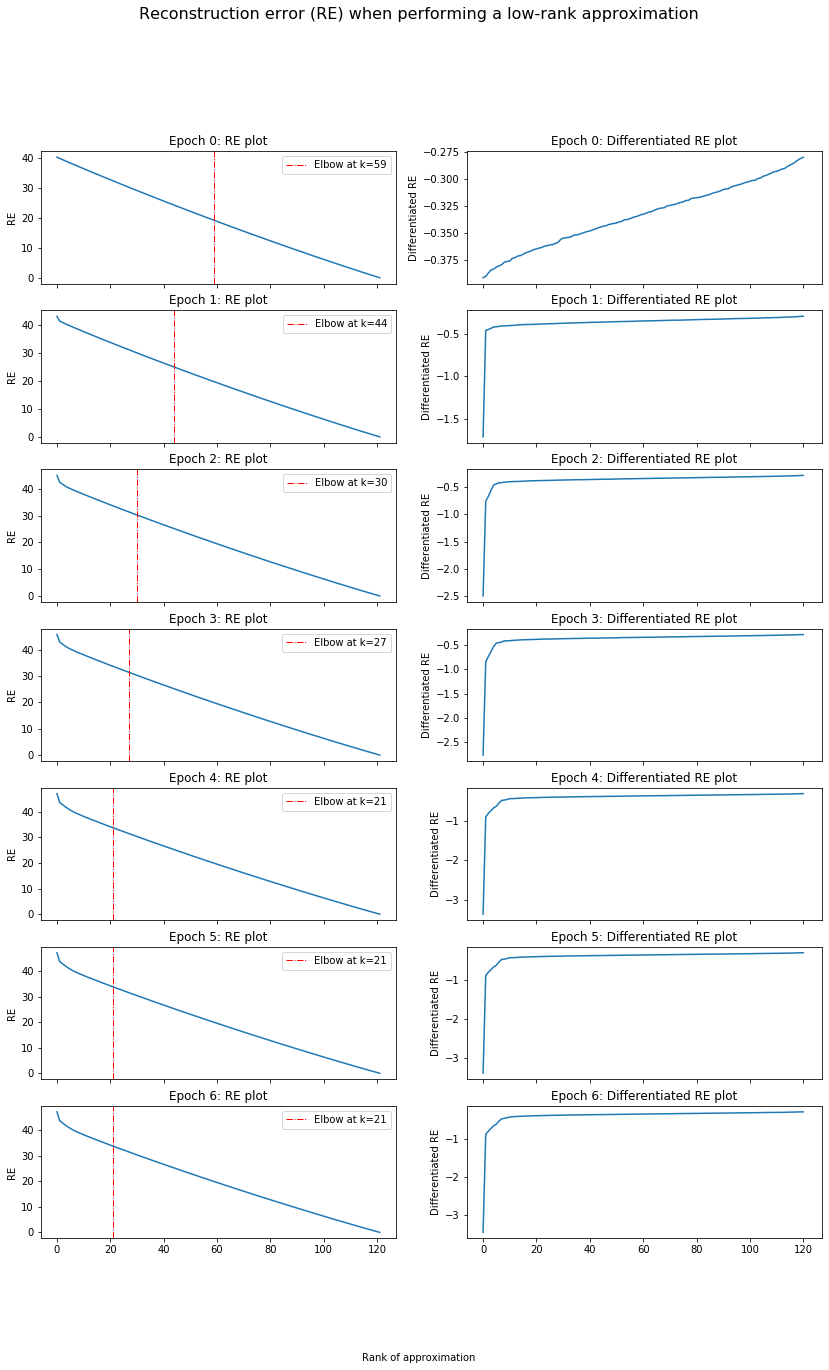

In [30]:
res_unselected = plot_reconstruction_error(s_unselected)

In [31]:
def orthogonal_projection(A, b):
    X, residuals, _, _ = np.linalg.lstsq(A, b, rcond=None)
    projections = A @ X
    return X, residuals, projections

In [32]:
def compare_residuals(u, b1, b2, rank=10):
    _, residuals1, _ = orthogonal_projection(u[:, :rank], b1)
    _, residuals2, _ = orthogonal_projection(u[:, :rank], b2)

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
    axs[0].hist(residuals1, bins=50)
    axs[0].set_title("Selected weight vectors at initialization")
    axs[1].hist(residuals2, bins=50)
    axs[1].set_title("Unselected weight vectors at initialization")
    
    fig.suptitle("Residual distribution when projecting on low-rank approximation of trained subspace", fontsize=16)
    fig.text(0.5, 0.04, 'Residual', ha='center')
    fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')
    
    plt.show()

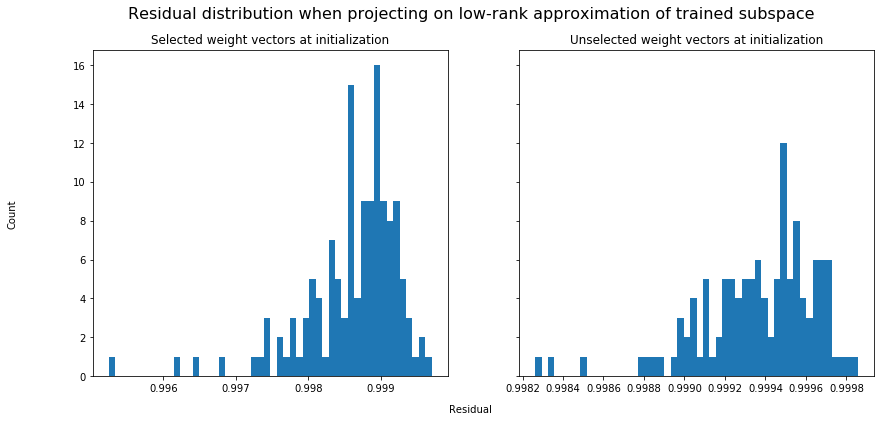

In [33]:
selected_b = w[0, selected_neurons, :].numpy().T
unselected_b = w[0, unselected_neurons, :].numpy().T
compare_residuals(u_selected[-1], selected_b, unselected_b, 10)

A possible reason for a weight vector to be chosen for training at initialization might be the closeness to the *trained subspace*. But the plot above shows no evidence to support that. Another reason could be that its projection onto the *trained subspace* is advantageous, hence training would mostly reduce the distance to the subspace. 

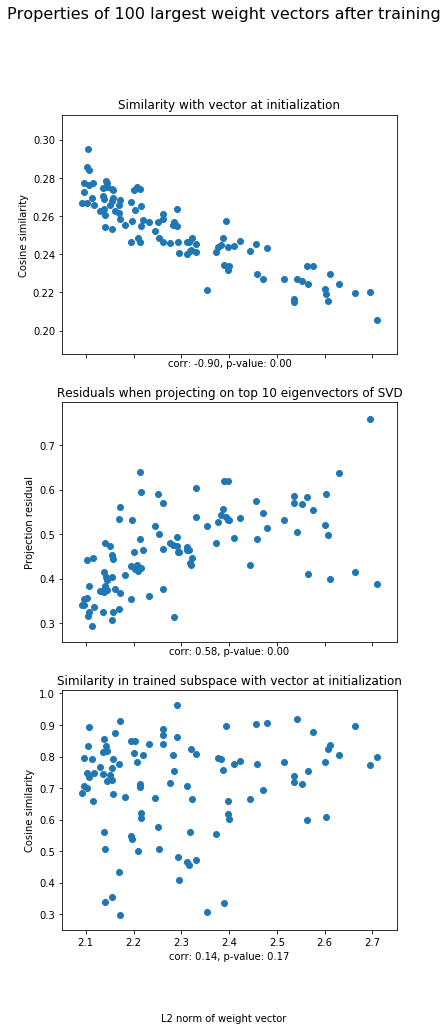

In [34]:
def top_weights_statistics(n_selected=50, rank=20):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 15))
    
    start = w[0].numpy().T
    end = w[-1].numpy().T
    indices = np.argsort(-weight_norms[-1])[:n_selected]
    x = weight_norms[-1][indices]
    
    similarity = np.diag(start.T @ end)
    y = similarity[indices]
    corr, p_value = pearsonr(x, y)
    axs[0].scatter(x, y)
    axs[0].set_title("Similarity with vector at initialization")
    axs[0].set_xlabel("corr: {:.2f}, p-value: {:.2f}".format(corr, p_value))
    axs[0].set_ylabel("Cosine similarity")
    
    _, _, projections1 = orthogonal_projection(u_full[-1][:, :rank], start)
    _, residuals, projections2 = orthogonal_projection(u_full[-1][:, :rank], end)
    y = residuals[indices]
    corr, p_value = pearsonr(x, y)
    axs[1].scatter(x, y)
    axs[1].set_title(f"Residuals when projecting on top {rank} eigenvectors of SVD")
    axs[1].set_xlabel("corr: {:.2f}, p-value: {:.2f}".format(corr, p_value))
    axs[1].set_ylabel("Projection residual")
    
    projections1 = projections1 / np.linalg.norm(projections1, axis=0)
    projections2 = projections2 / np.linalg.norm(projections2, axis=0)
    similarity = np.diag(projections1.T @ projections2)
    y = similarity[indices]
    corr, p_value = pearsonr(x, y)
    axs[2].scatter(x, y)
    axs[2].set_title("Similarity in trained subspace with vector at initialization")
    axs[2].set_xlabel("corr: {:.2f}, p-value: {:.2f}".format(corr, p_value))
    axs[2].set_ylabel("Cosine similarity")
    
    fig.suptitle(f"Properties of {n_selected} largest weight vectors after training", fontsize=16)
    fig.text(0.5, 0.04, 'L2 norm of weight vector', ha='center')
    plt.show()
    
top_weights_statistics(100, 10)  # 100, 30

The plot above indicates that the weight vectors which are trained the most are those that already are similar to their projection onto the *trained subspace*.

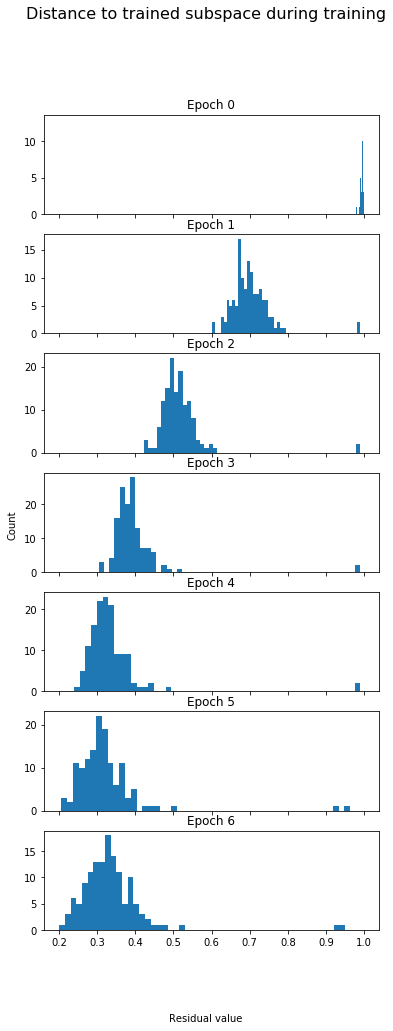

In [35]:
fig, axs = plt.subplots(epochs, 1, sharex=True, figsize=(6, 15))

for epoch in range(epochs):
    selected_b = w[epoch, selected_neurons, :].numpy().T
    _, residuals1, _ = orthogonal_projection(u_selected[-1][:, :20], selected_b)
    axs[epoch].hist(residuals1, bins=50)
    axs[epoch].set_title(f"Epoch {epoch}")
    
fig.suptitle("Distance to trained subspace during training", fontsize=16)
fig.text(0.5, 0.04, 'Residual value', ha='center')  
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')
plt.show()

## Experiments

In [97]:
train_batch_size = 64
test_batch_size = 1000
trainloader, testloader, _ = get_cifar(train_batch_size, test_batch_size)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [98]:
accuracy = s.evaluate_model(testloader, criterion, 0)


Test set: Average loss: 2.3030, Accuracy:   1000/ 10000 (10%)



In [99]:
accuracy = s.evaluate_model(testloader, criterion, epochs-1)


Test set: Average loss: 0.8494, Accuracy:   7792/ 10000 (78%)



In [100]:
selected_model = s.sub_network(epochs-1, layer, [])

In [101]:
e = Experiment(selected_model, criterion, None, {})

In [102]:
def projected_layer(experiment, layer, rank):
    new_experiment = experiment.clone()
    layer_weights = new_experiment.model.layer_weights(layer).numpy().T
    layer_weights_norm = np.linalg.norm(layer_weights)
    u, s, vh = np.linalg.svd(layer_weights, full_matrices=False)
    approximation = np.dot(u[:, :rank] * s[:rank], vh[:rank]).T
    new_layer_weights = approximation
    new_layer_weights_norm = np.linalg.norm(new_layer_weights)
    norms_ratio = new_layer_weights_norm / layer_weights_norm
    new_experiment.model.set_weights(layer, new_layer_weights)
    return new_experiment, norms_ratio

In [103]:
rank = 10
projected_e, norms_ratio = projected_layer(e, layer, rank)
print("Norms ratio (percentage): {:.2f}".format(100*norms_ratio))
accuracy, _ = projected_e.test(testloader, [])

Norms ratio (percentage): 61.43

Test set: Average loss: 0.9163, Accuracy:   7631/ 10000 (76%)



In [85]:
model_dir = "out/Conv6"
layer = "fc1"
rank = 10

network_dirs = [_ for _ in os.listdir(model_dir)]
accuracies = []
accuracies_proj = []
diffs = []
norms_ratios = []

for network_dir in network_dirs:
    base_dir = os.path.join(model_dir, network_dir)
    s_network = Snapshots(base_dir)
    acc_path = os.path.join(base_dir, common.METRICS_DIR, common.TRAINING_DIR, common.ACCURACY_FNAME)
    test_accuracies = np.load(acc_path)
    selected_model = s_network.sub_network(2, layer, [])
    e = Experiment(selected_model, criterion, None, {})
    accuracy, _ = e.test(testloader, [])
    accuracies.append(accuracy)
    projected_e, norms_ratio = projected_layer(e, layer, rank)
    norms_ratios.append(norms_ratio)
    print("Norms ratio (percentage): {:.2f}".format(100*norms_ratio))
    accuracy_proj, _ = projected_e.test(testloader, [])
    accuracies_proj.append(accuracy_proj)
    diffs.append(accuracy - accuracy_proj)


Test set: Average loss: 0.8239, Accuracy:   7544/ 10000 (75%)

Norms ratio (percentage): 56.33

Test set: Average loss: 1.0456, Accuracy:   7036/ 10000 (70%)


Test set: Average loss: 0.8223, Accuracy:   7623/ 10000 (76%)

Norms ratio (percentage): 56.79

Test set: Average loss: 0.9131, Accuracy:   7374/ 10000 (74%)


Test set: Average loss: 0.8776, Accuracy:   7505/ 10000 (75%)

Norms ratio (percentage): 55.37

Test set: Average loss: 1.0273, Accuracy:   7009/ 10000 (70%)


Test set: Average loss: 0.9831, Accuracy:   7430/ 10000 (74%)

Norms ratio (percentage): 55.30

Test set: Average loss: 1.1197, Accuracy:   7004/ 10000 (70%)


Test set: Average loss: 0.8480, Accuracy:   7628/ 10000 (76%)

Norms ratio (percentage): 56.52

Test set: Average loss: 0.9111, Accuracy:   7403/ 10000 (74%)


Test set: Average loss: 0.8339, Accuracy:   7521/ 10000 (75%)

Norms ratio (percentage): 57.25

Test set: Average loss: 1.0014, Accuracy:   7168/ 10000 (72%)


Test set: Average loss: 0.8476, Accurac

In [86]:
np_diffs = np.array(diffs)
norms_ratios_np = 100*np.array(norms_ratios)

In [87]:
np_diffs

array([5.08, 2.49, 4.96, 4.26, 2.25, 3.53, 2.96, 4.41, 2.45, 2.25])

In [88]:
print("Mean: {:.2f}".format(np_diffs.mean()))
print("Variance: {:.2f}".format(np_diffs.std()**2))

Mean: 3.46
Variance: 1.16


In [89]:
norms_ratios_np

array([56.329163, 56.792866, 55.37362 , 55.303528, 56.52156 , 57.246166,
       57.095425, 54.85756 , 56.766884, 59.00119 ], dtype=float32)

In [90]:
print("Mean: {:.2f}".format(norms_ratios_np.mean()))
print("Variance: {:.2f}".format(norms_ratios_np.std()**2))

Mean: 56.53
Variance: 1.27


## Model with resampled fc1 weights

In [43]:
new_output_dir = "out/Conv2-02_12_2019-12:09:41"
new_fp_paths, new_ip_paths, new_norms_paths = results_path(new_output_dir, layers)

In [44]:
new_acc_path = os.path.join(new_output_dir, common.METRICS_DIR, common.TRAINING_DIR, common.ACCURACY_FNAME)
new_test_accuracies = np.load(new_acc_path)
print("Best test accuracy at epoch N°", np.argmax(new_test_accuracies))

Best test accuracy at epoch N° 5


In [45]:
new_epochs = np.argmax(new_test_accuracies) + 1
new_weight_norms = np.load(new_norms_paths[layer])[:new_epochs]
new_s = Snapshots(new_output_dir)
new_weights = new_s.get_weights(layer)[:new_epochs]

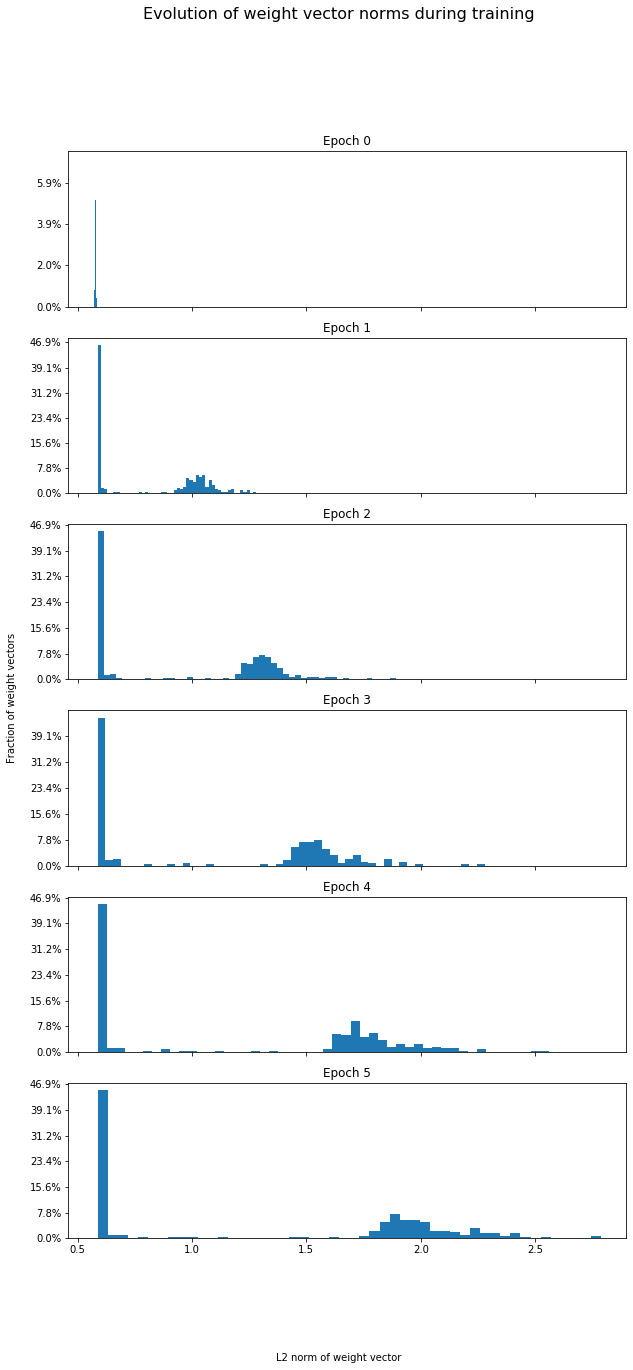

In [46]:
plot_training_norms(new_weight_norms)

In [47]:
new_w = torch.zeros(new_weights.shape)
# Normalize the weight vectors for every epoch
for epoch in range(new_epochs):
    new_w[epoch] = F.normalize(new_weights[epoch], p=2, dim=1)

In [48]:
new_trained_neurons = (new_weight_norms[-1] > cutoff)
new_selected_neurons = np.argwhere(new_trained_neurons).flatten().tolist()
new_unselected_neurons = np.argwhere(~new_trained_neurons).flatten().tolist()

In [49]:
new_u_selected, new_s_selected, new_vh_selected = svd(new_w[:, new_selected_neurons, :])
new_u_unselected, new_s_unselected, new_vh_unselected = svd(new_w[:, new_unselected_neurons, :])

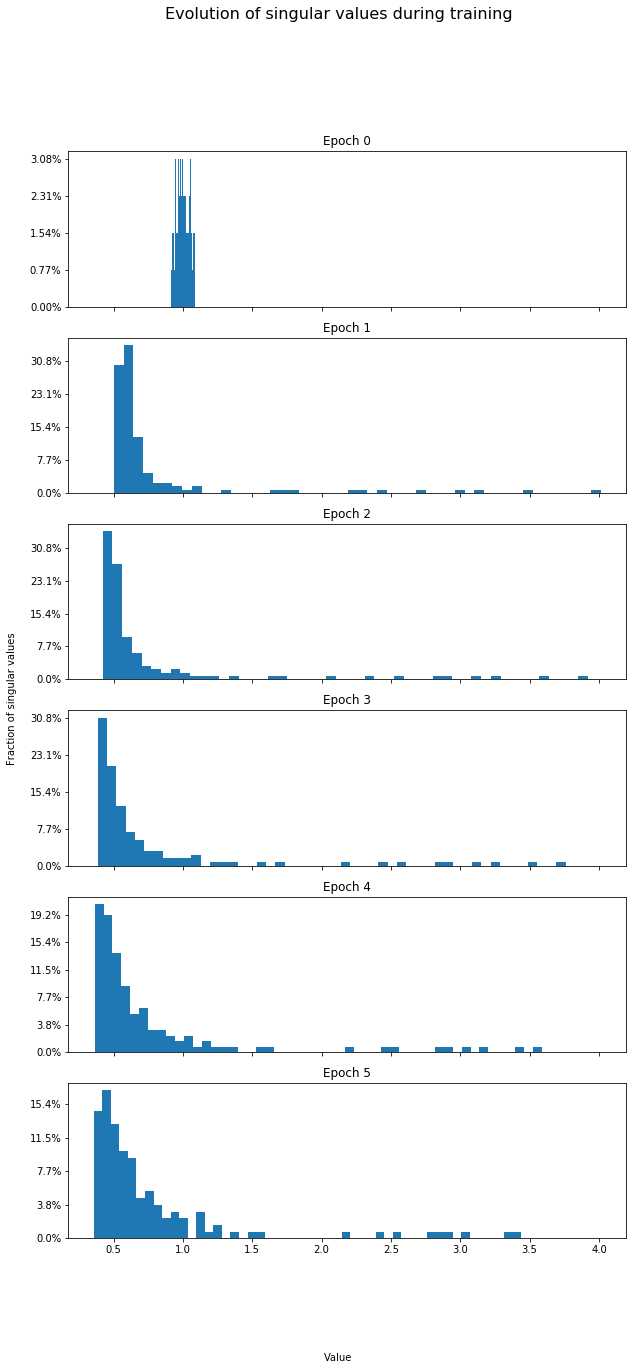

In [50]:
singular_value_distribution(new_s_selected)

In [51]:
np.rad2deg(subspace_angles(u_selected[-1][:, :10], new_u_selected[-1][:, :10]))

array([39.89787787, 38.0604951 , 37.08692631, 36.18484927, 35.36224047,
       34.62053493, 34.01188595, 33.71717085, 32.80429787, 31.13874434])

# Joint subspace analysis

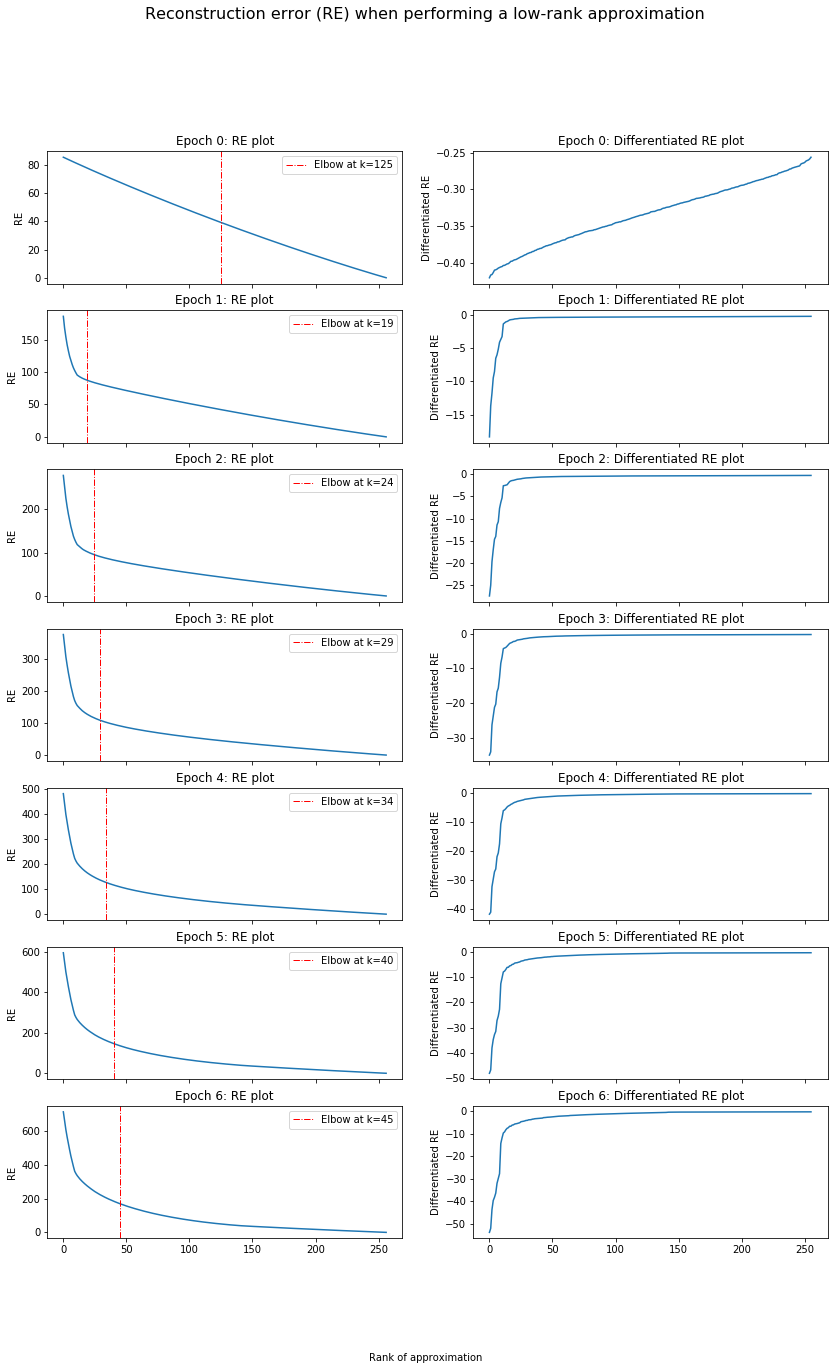

In [52]:
plot_reconstruction_error(s_full)

In [53]:
u_test, s_test, vh_test = svd(torch.cat((w[:-1], new_w), 1))

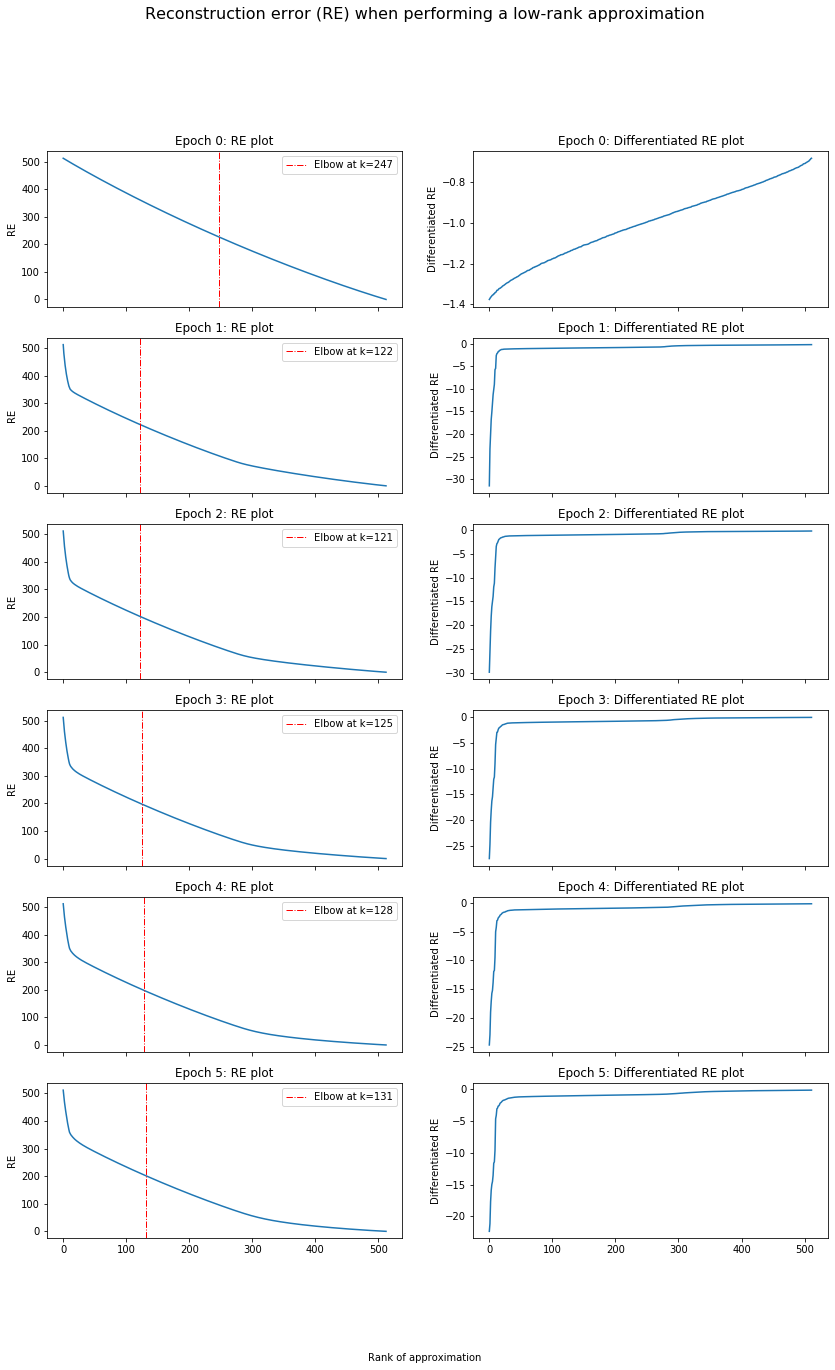

In [54]:
plot_reconstruction_error(s_test)